# Datasets characterization

In this notebook, we delve a bit into the datasets used for pre-training (i.e., GucaMol) and downstream evaluation (i.e., ADME by fang, et. al.). We look at the downstream data distributions and the distribution of the GucaMol and ADME datasets across six basic physicochemical properties.

In [1]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import r_regression

from paralell_data_processing import parallel_apply, process_molecules_in_parallel

## Defining setups
### ADME

Here, we identify the dataset location and handle the censored label problem that we found when plotting the data.
* censored labels refer to the problem of having molecules reporting values outside the assay's detectable range. Therefore, the true value of the measurement is not reported, but only a fixed value to report this case.
    * This case will affect a regression model's performance since it will be learning from incorrect values.
    * Change the `censored` variable at `L35` to `None` to process the data **without** the removal of these censored data.
    * We **arbitrary** set the threshold of censored labels to spanning 5% of the data because this aligns with what we observed from the data distribution. However, the detectable range should be known in advance for each assay.  

We show the number of molecules per endpoint before and after removing the censored labels.

In [2]:
datasets_dir = 'pretrain_and_downstream_datasets'
out_dir = 'analysis_figures/data_analysis'
os.makedirs(out_dir, exist_ok=True)

# Rename the columns of the ADME dataset to more easily-read names (just a beatification step)
data_cols = {
    "LOG SOLUBILITY PH 6.8 (ug/mL)": 'Solubility',
    "LOG MDR1-MDCK ER (B-A/A-B)": 'Permeability',
    "LOG HLM_CLint (mL/min/kg)": 'HLM',
    "LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)": 'hPPB',
    "LOG PLASMA PROTEIN BINDING (RAT) (% unbound)": 'rPPB',
    "LOG RLM_CLint (mL/min/kg)": 'RLM',
    }

# Provide the units of each endpoint since it was removed from the column name
target_value = {
    'Solubility': 'Log(ug/mL)',
    'Permeability': 'Log(efflux ratio)',
    'HLM': 'Log(mL/min/kg)',
    'hPPB': 'Log(% unbound)',
    'rPPB': 'Log(% unbound)',
    'RLM': 'Log(mL/min/kg)',}

# store the names of the datasets in a variable to use for looping when needed
datasets = data_cols.values()

# Load the ADME dataset and rename columns
adme = pd.read_csv(f'{datasets_dir}/ADME_public_set_3521.csv', index_col=0)
adme.rename(columns=data_cols, inplace=True)

# store the number of molecules tested per endpoint
num_molecules = {'# Molecules': {ds_name: len(adme[ds_name].dropna()) for ds_name in datasets}}

# Removing censored labels by setting a threshold of 5%. This means that if the same value was repeated more than 5% of the data, this value will be considered a censored label, and the corresponding molecules will be removed.
censored = 5  #None, 5
if censored:
    for dataset in datasets:
        value_counts = adme[dataset].value_counts(normalize=True) * 100
        
        # Identify values exceeding the threshold
        values_to_replace = value_counts[value_counts > censored].index
        
        # Remove rows with these values
        adme.loc[:, dataset] = adme[dataset].apply(lambda x: np.nan if x in values_to_replace else x)
    
    # recalculating the number of molecules per endpoint after removing censored labels
    num_molecules['# Molecules without censored labels'] = {ds_name: len(adme[ds_name].dropna()) for ds_name in datasets}
pd.DataFrame(num_molecules)       

,# Molecules,# Molecules without censored labels
Solubility,2173,2173
Permeability,2642,2642
HLM,3087,2129
hPPB,194,194
rPPB,168,168
RLM,3054,2708


## Defining plotting variables

In [3]:
descriptors_list = ['MW', 'TPSA', 'LogP', 'HBA', 'HBD', 'RotatableBonds']

def auto_centered_bins(data):   
    if 31 < data.max() < 100:
        bin_width = 3
    elif 100 < data.max() < 500:
        bin_width = 20
    elif data.max() > 500:
        bin_width = 50
    else:
        bin_width = 1
    
    # Compute centered bins
    min_val = np.floor(min(data) / bin_width) * bin_width
    max_val = np.ceil(max(data) / bin_width) * bin_width
    bins = np.arange(min_val - bin_width / 2, max_val + bin_width, bin_width)
    return bins

def plot_descriptors(df, descriptors_list, fig_dir, dataset=None, fig_name=''):
    # Plotting
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5))  # Adjust the size as needed
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    # Remove the last subplot if it's not needed (for an odd number of descriptors)
    if len(descriptors_list) % 2 != 0:
        fig.delaxes(axes[-1])
    
    if not isinstance(df, dict):
        df = {dataset: [df, 'blue']}
    
    for i, desc in enumerate(descriptors_list):
        ax1 = axes[i]  # Primary axis for scatter plot
        
        if dataset is not None:
            assert len(df) == 1
            
            curr_df = df[dataset][0]
            # Scatter plot
            ax2 = ax1.twinx()  # Secondary axis for PDF
            ax2.scatter(curr_df[desc], curr_df[dataset], color='skyblue', s=0.8, alpha=0.6, zorder=1)
            
            pearson_r = r_regression(curr_df[desc].values.reshape(-1, 1), curr_df[dataset].values)
            metrics_text = f"$R$ = {pearson_r[0]:.2f}"
            props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
            ax2.text(0.99, 0.88, metrics_text, transform=ax2.transAxes, fontsize=10,
                    verticalalignment='bottom', horizontalalignment='right', bbox=props)
            ax2.set_xlabel(desc)
            ax2.set_ylabel(target_value[dataset])
        
        # PDF plot
        # sns.kdeplot(ds_df[desc], fill=True, ax=ax2, color='skyblue', alpha=0.4, label='PDF')
        for ds_name, (database, color) in df.items():
            data = database[desc]
            bins = auto_centered_bins(data)
            sns.histplot(data, bins=bins, ax=ax1, color=color, label=ds_name)
            #sns.histplot(data, ax=ax1, color=colors[k])
            ax1.set_ylabel('Count')
            ax1.set_yscale('log')  # Set y-axis to log scale
            
            # Titles and legends
            ax1.set_title(f'Distribution of {desc}')
            if not dataset:
                ax1.legend()
    if dataset is not None:
        plt.suptitle(dataset, fontsize=18)
        plt.subplots_adjust(top=0.9)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f'{dataset if dataset is not None else f"{fig_name}"}_descriptors.pdf'))
    
    plt.show()        

## ADME - Calculating basic descriptors and Murcko scaffolds

We use six basic physicochemical properties that are known to be chemically intuitive an relevant:
1. Molecular weight (MW)
2. Topological polar surface area (TPSA)
3. Partition coefficient (LogP)
4. Hydrogen bond donors (HBD)
5. Hydrogen bond acceptors (HBA)
6. Rotatable bonds

Murcko scaffolds extract main subgroups of the molecules that are known to exhibit specific behaviours. 

**NB: The functions to calculate the descriptors and scaffolds can be found at the `paralell_data_processing.py` file. The descriptors and scaffolds are being calculated in parallel to speed the calculations for the GucaMol dataset mainly.**
**NB: The current parallelism uses all CPU cores.**

In [4]:
# Process descriptors and scaffolds in parallel
print("Processing molecules for descriptors and scaffolds...")
adme = parallel_apply(adme, process_molecules_in_parallel)
adme.drop('Descriptors', axis=1, inplace=True)

adme.head()

Processing molecules for descriptors and scaffolds...


/Users/afnan_sultan/miniconda3/envs/emtrl_datasail/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,Vendor ID,SMILES,CollectionName,HLM,Permeability,Solubility,hPPB,rPPB,RLM,molecules,MW,TPSA,LogP,HBA,HBD,RotatableBonds,Scaffold
Internal ID,,,,,,,,,,,,,,,,,
Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,NaN,1.493167,0.089905,0.991226,0.518514,1.392169,<rdkit.Chem.rdchem.Mol object at 0x305304590>,434.435,118.24,1.9007,9,3,6,O=C(NC1CC1)c1cnc2ccc(Nc3cccn(-c4ccccn4)c3=O)nn12
Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,NaN,1.040780,0.550228,0.099681,0.268344,NaN,<rdkit.Chem.rdchem.Mol object at 0x3053045e0>,418.444,89.27,4.1809,6,2,8,O=C(Nc1ccc2n[nH]cc2c1)c1ccccn1
Mol3,304005766,CN(c1ncc(F)cn1)[C@H]1CCCNC1,emolecules,NaN,-0.358806,NaN,2.000000,2.000000,NaN,<rdkit.Chem.rdchem.Mol object at 0x305304630>,210.256,41.05,0.8039,4,1,2,c1cnc(N[C@H]2CCCNC2)nc1
Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,NaN,1.026662,1.657056,-1.158015,-1.403403,NaN,<rdkit.Chem.rdchem.Mol object at 0x30573c6d0>,382.847,85.44,4.8932,4,2,5,c1ccc(-c2cncc(-c3ccccc3)c2)cc1
Mol5,324059015,CC(C)(O)CCn1cc2cc(NC(=O)c3cccc(C(F)(F)F)n3)c(C...,emolecules,0.99638,1.010597,NaN,1.015611,1.092264,1.629093,<rdkit.Chem.rdchem.Mol object at 0x305304720>,450.461,100.27,4.0908,6,3,6,O=C(Nc1ccc2n[nH]cc2c1)c1ccccn1


## ADME - Endpoints data distribution and summary
Here, we show the boxplots of each endpoint in the ADME benchmark. We also layout the individual points and the PDF function to have a feeling about the data clustering and scattering. 

The target values are provided as a log scale. Logging the target value is usually helpful during training an ML model when the values span a wide range, as logging provides smoothness over the data. 
* To have a feeling about the actual range of the target values outside the log scale, set `unlog` at `L1` to `True`.  

Plotting data points, data summary, and distribution for endpoints WITHOUT censored labels - target values are logged


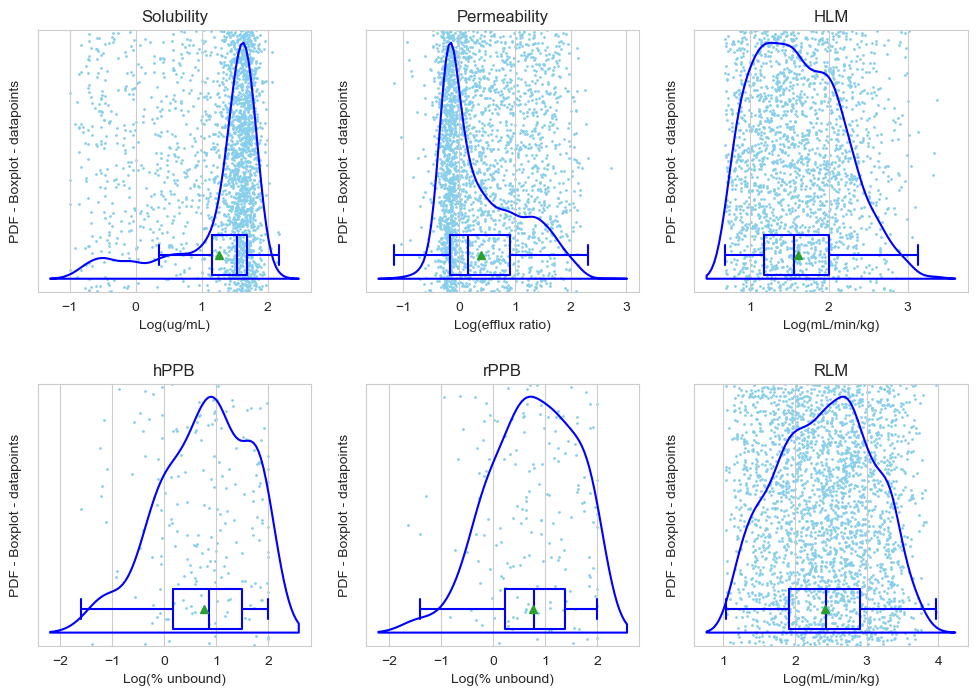

In [5]:
unlog = False

print(f'Plotting data points, data summary, and distribution for endpoints WITH{"OUT censored labels" if censored else " censored labels"} - target values are {"unlogged" if unlog else "logged"}')

fig_name = ''

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    
    ds_df = adme.dropna(subset=[dataset])
    
    if censored:
        fig_name = 'without_censors_'
    if unlog:
        if 'unlogged_' not in fig_name:
            fig_name += 'unlogged_'
        ds_df.loc[:, dataset] = np.exp(ds_df[dataset])
        unlogged_target_value = {key: value.replace('Log(', '').replace(')', '') for key, value in target_value.items()}
        
    
    # Create the violin plot
    sns.violinplot(data=ds_df[dataset], color='blue', width=0.9, fill=False, split=True, dodge=True, linewidth=1.5, zorder=2, inner=None, ax=ax, orient='h')
    
    # Create the boxplot (shifted)
    shift_value = 0.36
    x_positions_shifted = np.arange(1) + shift_value
    sns.boxplot(data=ds_df[dataset], color='blue', width=0.15, fill=False, showmeans=True, showfliers=False, positions=x_positions_shifted, zorder=1, ax=ax, orient='h')
    
    # Overlay individual data points
    strip = sns.stripplot(data=ds_df[dataset], color='skyblue', jitter=0.5, size=2, zorder=0, ax=ax, orient='h')
    
    #for collection in strip.collections:
     #   collection.set_offsets(collection.get_offsets() + np.array([0, 0.15]))  # Adjust the x-offset
    

    ax.set_xlabel(unlogged_target_value[dataset] if unlog else target_value[dataset])
    ax.set_ylabel('PDF - Boxplot - datapoints')
    ax.set_title(dataset)
    
plt.subplots_adjust(hspace=0.35)
plt.savefig(os.path.join(out_dir, f'{fig_name}endpoints_summary.pdf'))
plt.show()

## GuacaMol - Calculating basic descriptors and Murcko scaffolds

In [6]:
guacamol = pd.read_csv(f'{datasets_dir}/guacamol_v1_train.smiles', names=['SMILES'])

# Process descriptors and scaffolds in parallel
print("Processing molecules for descriptors and scaffolds...")
guacamol = parallel_apply(guacamol, process_molecules_in_parallel)
guacamol.drop('Descriptors', axis=1, inplace=True)

guacamol.head()

Processing molecules for descriptors and scaffolds...


/Users/afnan_sultan/miniconda3/envs/emtrl_datasail/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,SMILES,molecules,MW,TPSA,LogP,HBA,HBD,RotatableBonds,Scaffold
0,CCC(C)(C)Br,<rdkit.Chem.rdchem.Mol object at 0x3697cf010>,151.047,0.00,2.5699,0,0,1,
1,CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...,<rdkit.Chem.rdchem.Mol object at 0x3697cf060>,465.550,121.96,2.3340,5,3,9,O=C(NCCc1cccc(-c2ccccc2)c1)C1CCC=CO1
2,Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x3697cf0b0>,373.481,47.86,4.9403,3,2,3,S=C(Nc1ccccc1)N1N=C(c2ccccc2)CC1c1ccccc1
3,CC1(C)OCC2OC3(C4OC(C)(C)OC4CO)OC(C)(C)OC3C2O1,<rdkit.Chem.rdchem.Mol object at 0x3697cf100>,360.403,84.84,0.8969,8,1,2,C1OCC2OC3(C4COCO4)OCOC3C2O1
4,COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x3697cf150>,541.449,88.13,6.0754,8,0,10,C=C(c1ccccc1)c1ccccc1


## Quantifying both datasets

Here, we show the number of molecules and unique Murcko scaffold per dataset to examine each dataset diversity. We also show the intersection between molecules and scaffolds to examine the diversity between the two datasets. 
* NB: We did not perform our own standardization on the molecules from GuacaMol and ADME. So, there is a risk that the same molecule exists in both datasets, but undetectable by the intersection analysis 
* NB: extracting scaffolds by RDKit requires standardization first, so, all shared scaffolds should be detected correctly. However, it is not guaranteed that the model has detected these scaffolds (since the molecules were not standardized befor given to the model)


In [7]:
counts = {
    'GuacaMol': {'# Molecules': len(guacamol), 
                 '# Unique Murcko scaffolds': len(guacamol['Scaffold'].unique())},
    'ADME': {'# Molecules': len(adme),
             '# Unique Murcko scaffolds': len(adme['Scaffold'].unique())},
    'GuacaMol ∩ ADME': {'# Molecules':  len(set(guacamol['SMILES']).intersection(set(adme['SMILES']))), 
                        '# Unique Murcko scaffolds': len(set(guacamol['Scaffold']).intersection(set(adme['Scaffold'])))},
    }
pd.DataFrame(counts)

,GuacaMol,ADME,GuacaMol ∩ ADME
# Molecules,1273104,3521,286
# Unique Murcko scaffolds,407408,2988,1116


## GucaMol vs ADME - PhysChem descriptors distributions

Plotting the distribution of both pre-training and downstream datasets per each physchem descriptor to examine the similarity and differences between the two datasets for these descriptors

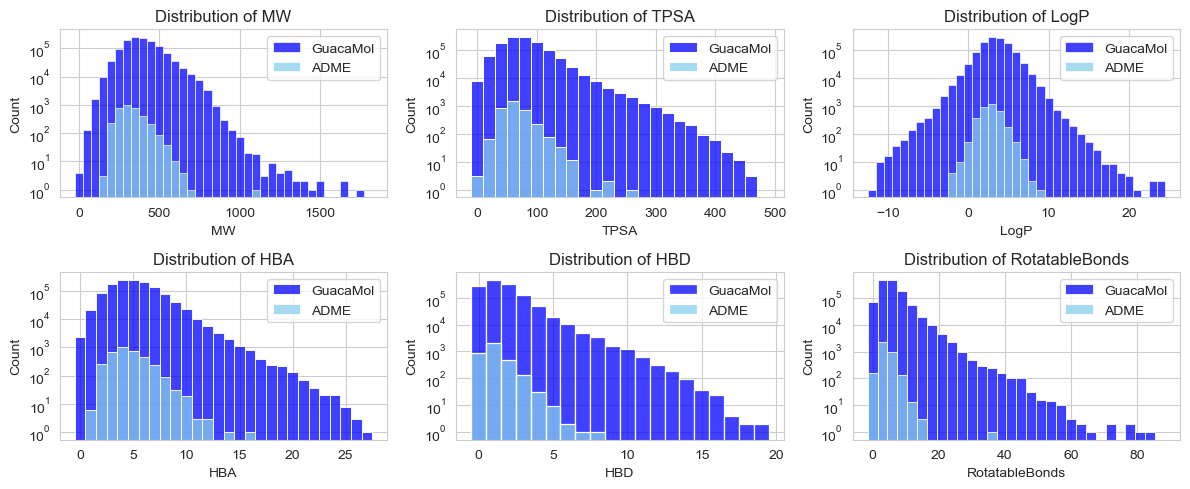

In [8]:
plot_descriptors({'GuacaMol': [guacamol, 'blue'], 'ADME': [adme, 'skyblue']}, descriptors_list, fig_dir=out_dir, fig_name='pretrain_vs_adme')

## Endpoint vs basic physchem descriptors

Plotting the distribution of each endpoint against the basic six physicochemical properties. The individual points are also plotted for each endpoint to have a feeling about the trand of the target values. 

The pearson r correlation is shown for each descriptor. 

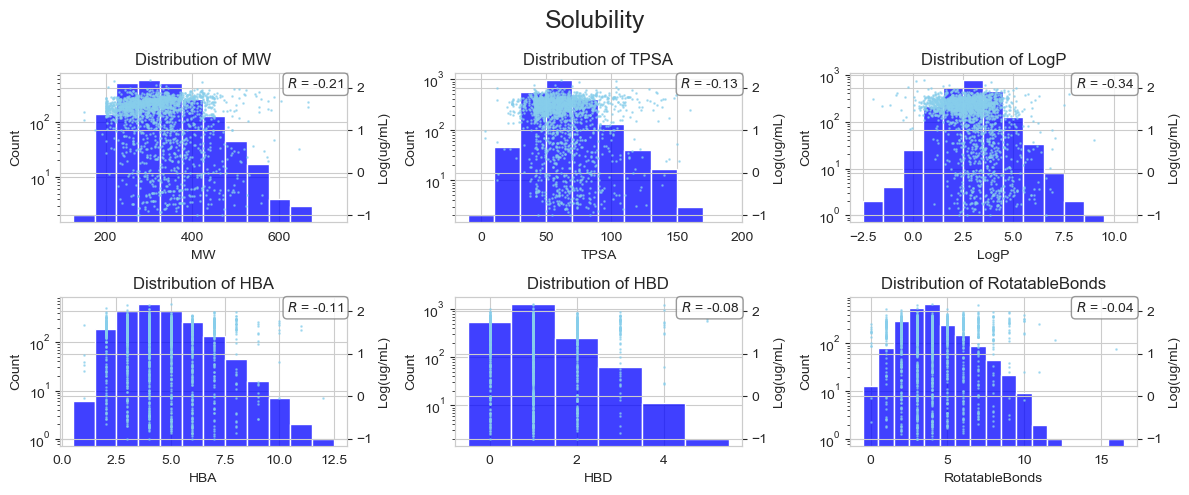

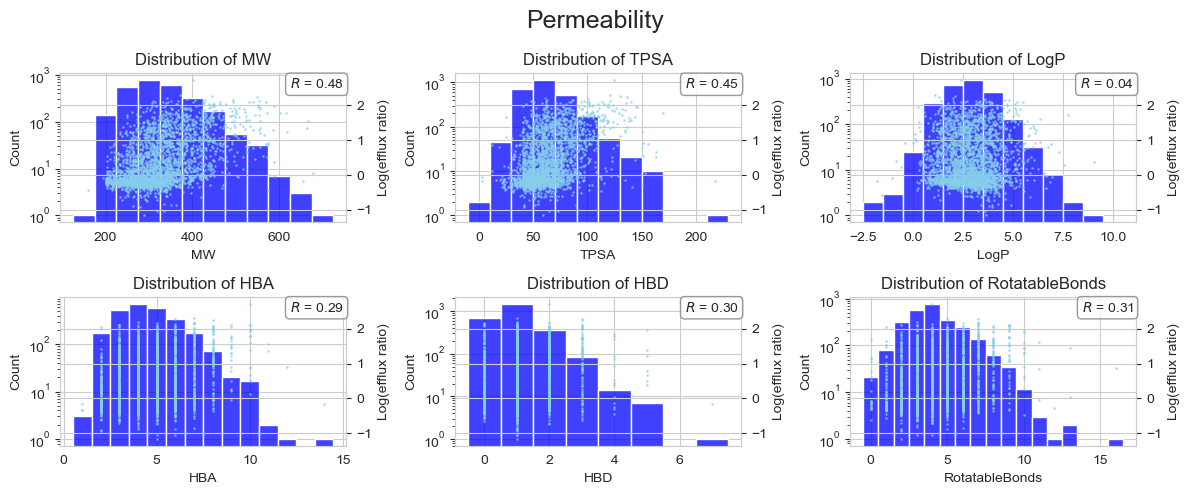

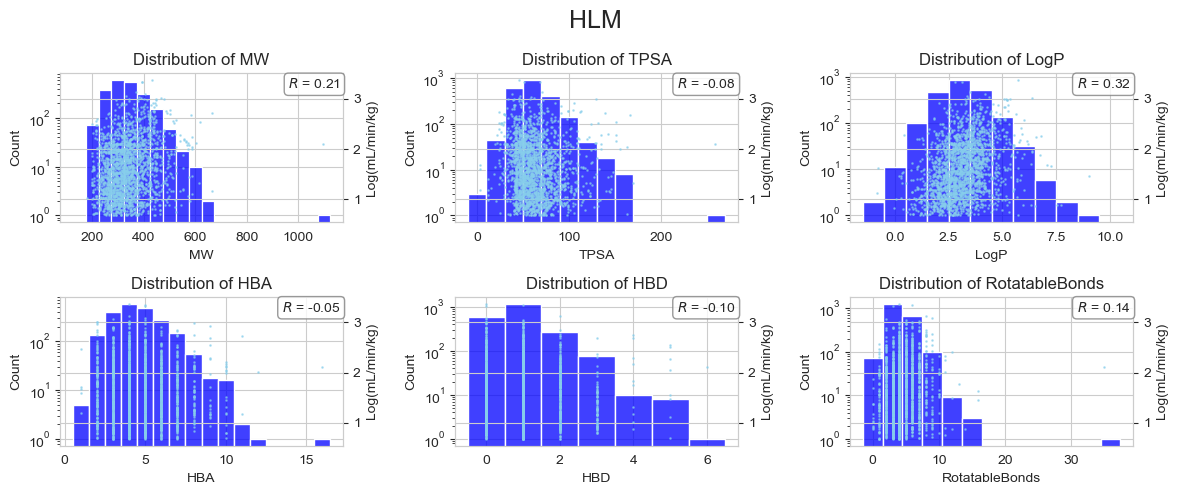

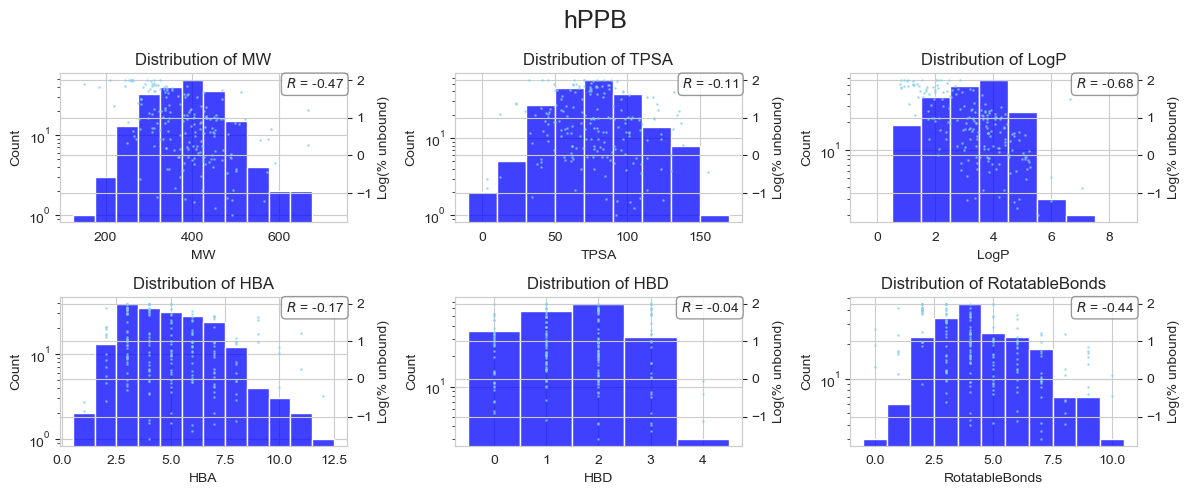

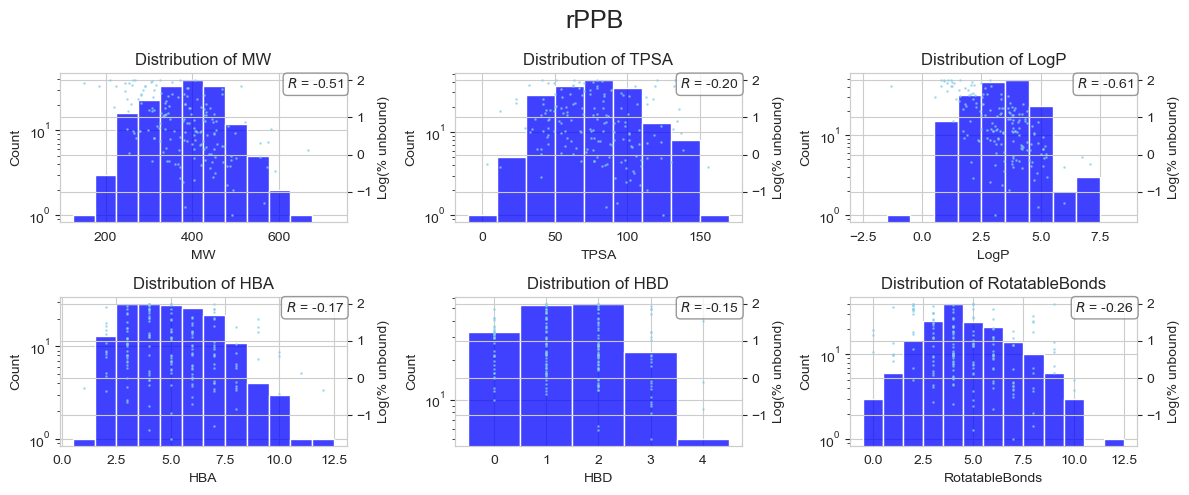

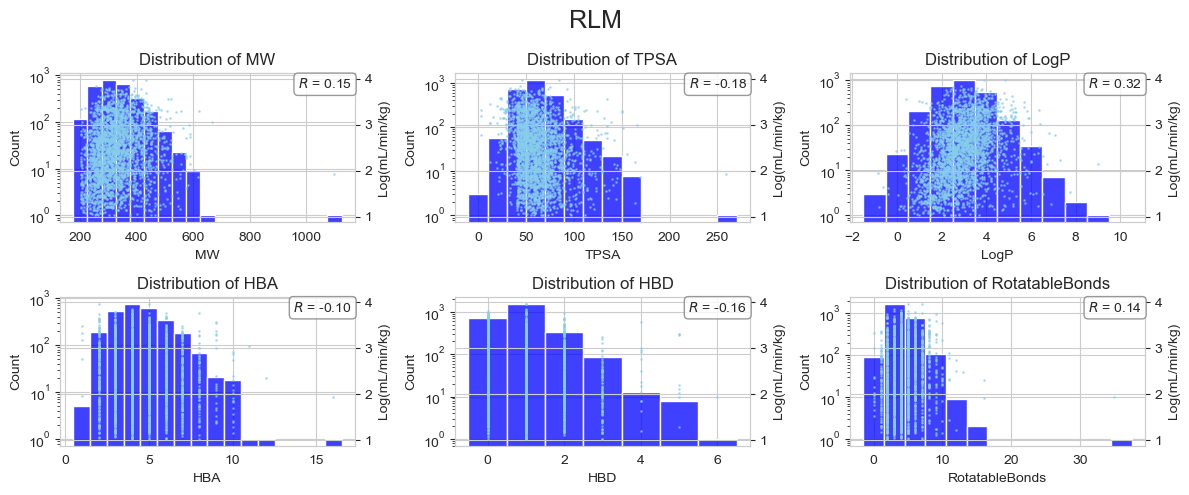

In [9]:
for dataset in datasets:
    ds_df = adme.dropna(subset=[dataset])
    # ds_df.loc[:, 'Butina Cluster'] = butina_cluster(ds_df['molecules'].values)
    #plot_most_common_scaffolds(ds_df, dataset=dataset)
    plot_descriptors(ds_df, descriptors_list, fig_dir=out_dir, dataset=dataset)
    
    # uncomment the below line to plot each endpoint against the GuacaMol dataset. 
    #plot_descriptors({'GuacaMol': [guacamol, 'blue'], dataset: [ds_df, 'skyblue']}, descriptors_list, fig_dir=out_dir, fig_name=f'pre-train_vs_{dataset}')